# PAMA-seq

16S+18S co-sequenging
In this experiment, we requested the metagenomic data of the zymo standard 10 cell mixture. 
Use this data, I will calculate the relative abundance
1. the raw reads are aligned to reference by bowtie2
2. analyze the aligned read counts.
3. normalize the read count by the genome size and the copy numbers of 16s and 18s gene.
4. compare it to the PA-seq data

### Read counts:
```
pam-seq_rep1: 1280256
pam-seq_rep2: 1248542
pam-seq_rep3: 1542436

meta: 8109765

sub sample the metagenomic to 2 Million reads. 
then compare the two methods with 3 replicates. 
the files are saved in file: '/home/xiangpeng/projects/16S_18S/Zymo/meta/in3168_subsamples/'

Run the following command to subsample the reads. 
seqtk sample -s100 in3168_1_R1.fastq.gz 2000000 > in3168_subsamples/sub_rep1_2000000_R1.fq
seqtk sample -s10 0in3168_1_R2.fastq.g q2010000  >in3168_subsamples/sub_rep1_2000000_R2.fq
seqtk sample -s200 in3168_1_R1.fastq.gz 2000000 > in3168_subsamples/sub_rep2_2000000_R1.fq
seqtk sample -s200 in3168_1_R2.fastq.gz 2000000 > in3168_subsamples/sub_rep2_2000000_R2.fq

seqtk sample -s300 in3168_1_R1.fastq.gz 2000000 > in3168_subsamples/sub_rep3_2000000_R1.fq
seqtk sample -s300 in3168_1_R2.fastq.gz 2000000 > in3168_subsamples/sub_rep3_2000000_R2.fq'

reference bt2 file: '/home/xiangpeng/ref/ZymoBIOMICS.STD.refseq.v2/Genomes/zymo/zymo

bowtie2 -x /home/xiangpeng/ref/ZymoBIOMICS.STD.refseq.v2/Genomes/zymo/zymo -1sub_rep1_2000000_R1.fq.gzz -2sub_rep1_2000000_R2.fq.gzz -p 12 | samtools view -bS -o zymo_rep1.bam -q 0bowtie2 -x /home/xiangpeng/ref/ZymoBIOMICS.STD.refseq.v2/Genomes/zymo/zymo -1 sub_rep2_2000000_R1.fq.gz -2 sub_rep2_2000000_R2.fq.gz -p 12 | samtools view -bS -o zymo_rep2.bam -q 0
bowtie2 -x /home/xiangpeng/ref/ZymoBIOMICS.STD.refseq.v2/Genomes/zymo/zymo -1 sub_rep3_2000000_R1.fq.gz -2 sub_rep3_2000000_R2.fq.gz -p 12 | samtools view -bS -o zymo_rep3.bam -q 00
samtools view -q 1 zymo_rep1.bam |awk -F'\t' '{ print $3}'|sort| uniq -c > zymo_meta_rep1.txt
samtools view -q 1 zymo_rep2.bam |awk -F'\t' '{ print $3}'|sort| uniq -c > zymo_meta_rep2.txt
samtools view -q 1 zymo_rep3.bam |awk -F'\t' '{ print $3}'|sort| uniq -c > zymo_meta_rep3.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [16]:
wk_dir = '/home/xiangpeng/projects/16S_18S/code_for_github/data/zymo/'

zymo_meta = pd.DataFrame()
for i in [1,2,3]:
    file = pd.read_csv(wk_dir+'in3168_subsamples/zymo_meta_rep{}.txt'.format(i),sep='\s+', index_col = 1, names =['rep{}'.format(i), 'contig'])
    zymo_meta = pd.concat([zymo_meta, file], axis=1)
zymo_meta =zymo_meta.fillna(0)
zymo_meta.head()

,rep1,rep2,rep3
contig,,,
10092,2.0,2.0,0.0
1018,1.0,4.0,0.0
10200,1.0,1.0,0.0
10300,5.0,0.0,2.0
10314,1.0,1.0,0.0


In [17]:
contig_genus_file = wk_dir + 'zymo_contig.txt'
# Open the text file in read mode
with open(contig_genus_file, 'r') as file:
    # Iterate over each line in the file
    contig_genus ={}
    for line in file:
        genus = line.split('_')[0]
        contig = line.split('>')[1].split(' ')[0].split('\n')[0]
        contig_genus[contig]=genus

In [18]:
contig_length_file = wk_dir + 'header.txt'
# Open the text file in read mode
with open(contig_length_file, 'r') as file:
    # Iterate over each line in the file
    contig_length ={}
    for line in file:
        len = int(line.split('LN:')[1].split('\n')[0])
        contig = line.split('SN:')[1].split('\t')[0]
        contig_length[contig]=len
        

In [19]:
zymo_meta['genus']=zymo_meta.index.map(contig_genus)
zymo_meta['ref_len']=zymo_meta.index.map(contig_length)

In [20]:
zymo_meta.head()

,rep1,rep2,rep3,genus,ref_len
contig,,,,,
10092,2.0,2.0,0.0,Cryptococcus,171
1018,1.0,4.0,0.0,Cryptococcus,249
10200,1.0,1.0,0.0,Cryptococcus,161
10300,5.0,0.0,2.0,Cryptococcus,231
10314,1.0,1.0,0.0,Cryptococcus,161


In [21]:
### Zymo theratical abundance
genus_cnt = zymo_meta.groupby('genus').sum()
rrna_copy = {'Bacillus': 10,
 'Cryptococcus':60,
 'Enterococcus':4,
 'Escherichia':7,
 'Lactobacillus':5,
 'Listeria':6,
 'Pseudomonas': 4,
 'Saccharomyces':109,
 'Salmonella':7,
 'Staphylococcus':6}
genus_cnt['rrna cnt'] = genus_cnt.index.map(rrna_copy)
genus_genosize = {'Bacillus': 4.045,
 'Cryptococcus':18.9,
 'Enterococcus':2.845,
 'Escherichia':4.875,
 'Lactobacillus':1.905,
 'Listeria':2.992,
 'Pseudomonas': 6.792,
 'Saccharomyces':12.1,
 'Salmonella':4.760,
 'Staphylococcus':2.730}
genus_cnt['geno_size'] = genus_cnt.index.map(genus_genosize)

In [22]:
for i in [1,2,3]:
    # normalize the cell count by reference genome length
    genus_cnt['cell_cnt_rep_{}'.format(i)]= genus_cnt['rep{}'.format(i)].div(genus_cnt['ref_len'])
    genus_cnt['cell_cnt_rel_rep_{}'.format(i)]= genus_cnt['cell_cnt_rep_{}'.format(i)].div(genus_cnt['cell_cnt_rep_{}'.format(i)].sum())
    # normalize the cell count by rRNA counts
    genus_cnt['rna_cnt_rep_{}'.format(i)]= genus_cnt['cell_cnt_rep_{}'.format(i)]*(genus_cnt['rrna cnt'])
    genus_cnt['rna_cnt_rel_rep_{}'.format(i)]= genus_cnt['rna_cnt_rep_{}'.format(i)].div(genus_cnt['rna_cnt_rep_{}'.format(i)].sum())

In [23]:
#cell count relative abundance
genus_cnt['cell_cnt_average'] = genus_cnt[['cell_cnt_rel_rep_1','cell_cnt_rel_rep_2','cell_cnt_rel_rep_3']].mean(axis=1)
genus_cnt['cell_cnt_std'] = genus_cnt[['cell_cnt_rel_rep_1','cell_cnt_rel_rep_2','cell_cnt_rel_rep_3']].std(axis=1)

#rRNA copy relative abundance
genus_cnt['rna_average'] = genus_cnt[['rna_cnt_rel_rep_1','rna_cnt_rel_rep_2','rna_cnt_rel_rep_3']].mean(axis=1)
genus_cnt['rna_std'] = genus_cnt[['rna_cnt_rel_rep_1','rna_cnt_rel_rep_2','rna_cnt_rel_rep_3']].std(axis=1)

In [24]:
genus_cnt.head()#['count'].plot.pie()

,rep1,rep2,rep3,ref_len,rrna cnt,geno_size,cell_cnt_rep_1,cell_cnt_rel_rep_1,rna_cnt_rep_1,rna_cnt_rel_rep_1,...,rna_cnt_rep_2,rna_cnt_rel_rep_2,cell_cnt_rep_3,cell_cnt_rel_rep_3,rna_cnt_rep_3,rna_cnt_rel_rep_3,cell_cnt_average,cell_cnt_std,rna_average,rna_std
genus,,,,,,,,,,,,,,,,,,,,,
Bacillus,194143.0,193413.0,193905.0,4045677,10,4.045,0.047988,0.108737,0.479878,0.163619,...,0.478073,0.163256,0.047929,0.108534,0.479289,0.163329,0.108545,0.000187,0.163401,0.000192
Cryptococcus,23638.0,23616.0,23485.0,28065853,60,18.900,0.000842,0.001908,0.050534,0.017230,...,0.050487,0.017241,0.000837,0.001895,0.050207,0.017109,0.001904,0.000008,0.017193,0.000073
Enterococcus,183386.0,183493.0,184517.0,2845392,4,2.845,0.064450,0.146039,0.257801,0.087900,...,0.257951,0.088087,0.064848,0.146846,0.259391,0.088394,0.146353,0.000432,0.088127,0.000249
Escherichia,201068.0,201656.0,201104.0,4875441,7,4.875,0.041241,0.093449,0.288687,0.098430,...,0.289531,0.098871,0.041248,0.093406,0.288739,0.098395,0.093536,0.000189,0.098565,0.000266
Lactobacillus,150007.0,150028.0,149946.0,1905333,5,1.905,0.078730,0.178396,0.393650,0.134219,...,0.393705,0.134446,0.078698,0.178210,0.393490,0.134091,0.178362,0.000139,0.134252,0.000180


<Axes: ylabel='rna_average'>

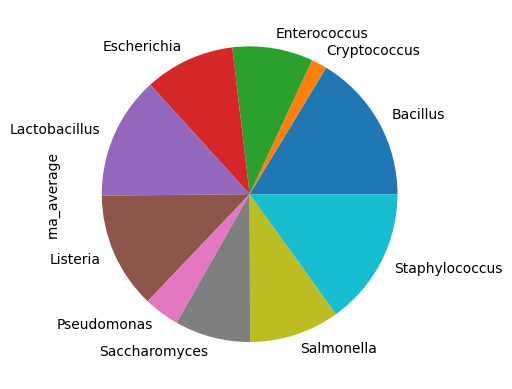

In [25]:
genus_cnt['rna_average'].plot.pie()

<Axes: ylabel='cell_cnt_average'>

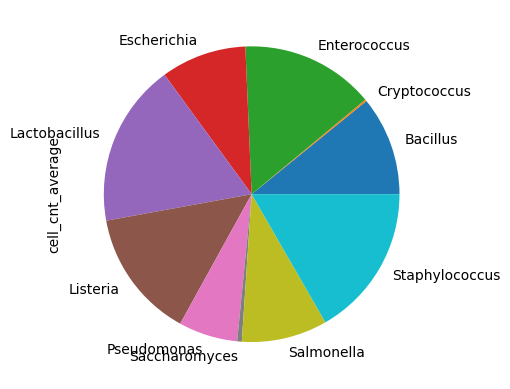

In [28]:
genus_cnt['cell_cnt_average'].plot.pie()


In [29]:
out_dir = '/home/xiangpeng/projects/16S_18S/code_for_github/output/zymo/'
genus_cnt.to_csv(out_dir+'zymo_meta_calculated_abundance.csv')

In [33]:

#read PAMA-seq data
pa_seq = pd.read_csv(wk_dir + 'zymo_pam-seq_read_cnt.csv', index_col=0)
# read theratical abundance
theory = pd.read_csv(wk_dir+'Zymo_theratical.csv', index_col=0)

In [34]:
pa_seq

,rep1,rep2,rep3,rep_rel_1,rep_rel_2,rep_rel_3,average,stdev
genus,,,,,,,,
Bacillus,231267,279215,269317,0.187227,0.210445,0.166907,0.188193,0.021785
Cryptococcus,88658,42716,76552,0.071775,0.032195,0.047442,0.050471,0.019963
Enterococcus,95459,120311,142597,0.077281,0.090679,0.088373,0.085444,0.007163
Escherichia,97101,116176,168737,0.078610,0.087562,0.104573,0.090249,0.013188
Lactobacillus,73145,87238,103448,0.059216,0.065752,0.064111,0.063026,0.003400
Listeria,161863,164601,200117,0.131039,0.124060,0.124021,0.126374,0.004041
Pseudomonas,34676,41708,48427,0.028073,0.031435,0.030012,0.029840,0.001688
Saccharomyces,183908,171686,287281,0.148886,0.129400,0.178040,0.152109,0.024479
Salmonella,100436,115449,156201,0.081310,0.087014,0.096804,0.088376,0.007836


In [35]:
theory

,theroretical_rRNA,theroretical_rel_rRNA,theoretical_genome_copy,theoretical_rel_genome_copy,theoretical_cell_number,theoretical_rel_cell_number
genus,,,,,,
Bacillus,15.3,0.152542,10.30,0.103165,10.30,0.103134
Cryptococcus,3.3,0.032901,0.37,0.003706,0.18,0.001802
Enterococcus,8.7,0.086740,14.60,0.146234,14.60,0.146190
Escherichia,8.9,0.088734,8.50,0.085136,8.50,0.085111
Lactobacillus,16.1,0.160518,21.60,0.216346,21.90,0.219285
Listeria,12.4,0.123629,13.90,0.139223,13.90,0.139181
Pseudomonas,3.6,0.035892,6.10,0.061098,6.10,0.061079
Saccharomyces,9.3,0.092722,0.57,0.005709,0.29,0.002904
Salmonella,9.1,0.090728,8.70,0.087139,8.80,0.088115


In [36]:
pa_vs_meta = pd.DataFrame()
pa_vs_meta['meta']=genus_cnt['rna_average']
pa_vs_meta['pa'] = pa_seq['average']
pa_vs_meta['theory'] = theory['theroretical_rel_rRNA']

pa_vs_meta['meta_error']=genus_cnt['rna_std']
pa_vs_meta['pa_error'] = pa_seq['stdev']

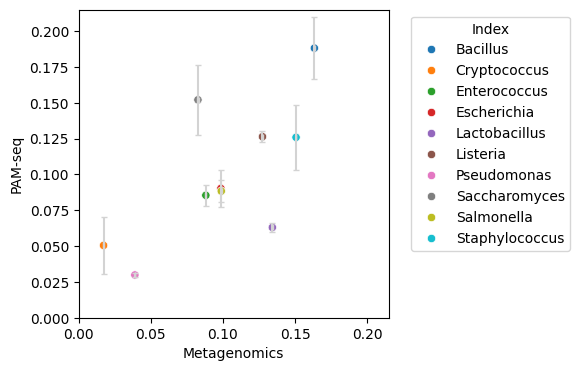

In [38]:
plt.figure(figsize=(4,4))
plt.errorbar(pa_vs_meta['meta'], 
             pa_vs_meta['pa'], 
             xerr=pa_vs_meta['meta_error'],
             yerr=pa_vs_meta['pa_error'], 
             ecolor='lightgray', 
             linestyle='None',
             fmt='',
             capsize=2)
sns.scatterplot(data= pa_vs_meta,
                x='meta',
                y='pa',
                hue = pa_vs_meta.index,
               # marker='^',
                #facecolors='none',
               )



plt.xlabel('Metagenomics')
plt.ylabel('PAM-seq')
#plt.title('Plot of y2 vs. x')
#plt.grid(True)

#plt.plot([0, 0.2], [0, 0.2], linestyle='--', color='red')

plt.legend(title='Index', bbox_to_anchor=(1.05, 1), loc='upper left')
# Set x and y ranges
plt.xlim(0, 0.215)
plt.ylim(0, 0.215)
plt.savefig(out_dir+'Zymo_rrna_relative_pam_vs_meta.pdf', bbox_inches='tight')
plt.show()

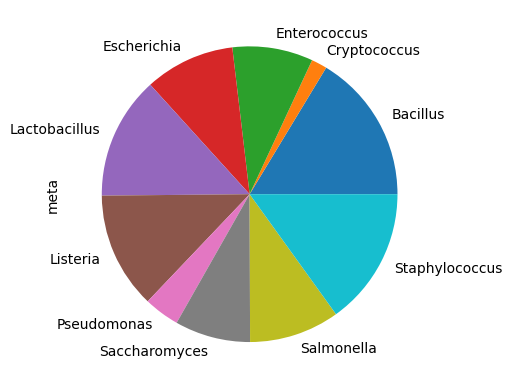

In [40]:
pa_vs_meta['meta'].plot.pie()
plt.savefig(out_dir+'Zymo_rrna_relative_abundance_meta.pdf', bbox_inches='tight')

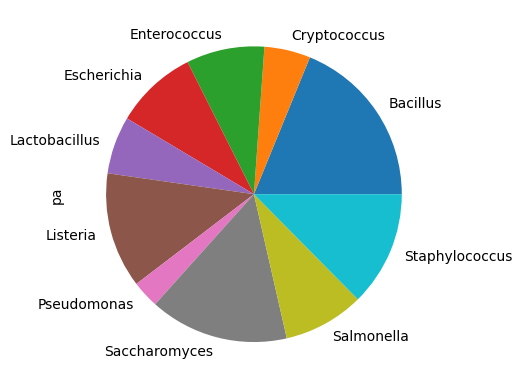

In [39]:
pa_vs_meta['pa'].plot.pie()
plt.savefig(out_dir+'Zymo_rrna_relative_abundance_pie_pam-seq.pdf', bbox_inches='tight')

In [41]:
pa_vs_meta

rho, p_value = stats.spearmanr(pa_vs_meta['meta'], pa_vs_meta['theory'])

print(f"meta_vs_theory Spearman Correlation Coefficient (Rho): {rho}")
print(f"P-value: {p_value}")

meta_vs_theory Spearman Correlation Coefficient (Rho): 0.8909090909090909
P-value: 0.0005421442248338665


In [42]:
pa_vs_meta

rho, p_value = stats.spearmanr(pa_vs_meta['pa'], pa_vs_meta['theory'])

print(f"PAMA_vs_therory_Spearman Correlation Coefficient (Rho): {rho}")
print(f"P-value: {p_value}")

PAMA_vs_therory_Spearman Correlation Coefficient (Rho): 0.5878787878787878
P-value: 0.07387770688865801


In [43]:

rho, p_value = stats.spearmanr(pa_vs_meta['pa'], pa_vs_meta['meta'])

print(f"Spearman Correlation Coefficient (Rho): {rho}")
print(f"P-value: {p_value}")

Spearman Correlation Coefficient (Rho): 0.5757575757575757
P-value: 0.08155281477260236


In [44]:
pa_vs_meta['pa_meta_ratio'] = pa_vs_meta['pa'].div(pa_vs_meta['meta'])
pa_vs_meta['pa_theory_ratio'] = pa_vs_meta['pa'].div(pa_vs_meta['theory'])
pa_vs_meta


,meta,pa,theory,meta_error,pa_error,pa_meta_ratio,pa_theory_ratio
genus,,,,,,,
Bacillus,0.163401,0.188193,0.152542,0.000192,0.021785,1.151723,1.233710
Cryptococcus,0.017193,0.050471,0.032901,0.000073,0.019963,2.935494,1.534008
Enterococcus,0.088127,0.085444,0.086740,0.000249,0.007163,0.969562,0.985065
Escherichia,0.098565,0.090249,0.088734,0.000266,0.013188,0.915621,1.017071
Lactobacillus,0.134252,0.063026,0.160518,0.000180,0.003400,0.469463,0.392642
Listeria,0.127406,0.126374,0.123629,0.000405,0.004041,0.991895,1.022199
Pseudomonas,0.038886,0.029840,0.035892,0.000098,0.001688,0.767382,0.831379
Saccharomyces,0.082641,0.152109,0.092722,0.000795,0.024479,1.840606,1.640487
Salmonella,0.098842,0.088376,0.090728,0.000509,0.007836,0.894118,0.974081


<Figure size 400x400 with 0 Axes>

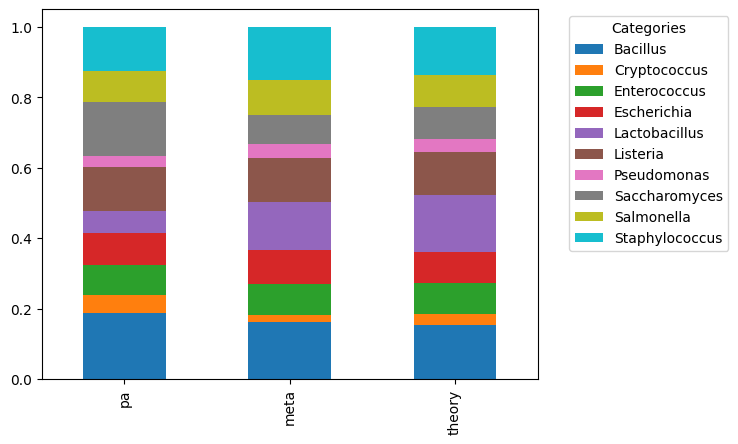

In [45]:
plt.figure(figsize=(4,4))
pa_vs_meta[['pa','meta','theory']].T.plot.bar(stacked=True)
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(out_dir+'Zymo_rrna_relative_abundance_pam_meta_theory_stacked_bar.pdf', bbox_inches='tight')

In [46]:
from scipy.stats import pearsonr
# Function to calculate correlation and p-value
def corr_with_pvalue(df):
    cols = df.columns
    pval_matrix = pd.DataFrame(index=cols, columns=cols)
    corr_matrix = df.corr()

    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                pval_matrix.loc[col1, col2] = None
            else:
                corr, pval = pearsonr(df[col1], df[col2])
                pval_matrix.loc[col1, col2] = pval

    return corr_matrix, pval_matrix

# Calculate correlation matrix and p-value matrix
correlation_matrix, pvalue_matrix = corr_with_pvalue(pa_vs_meta[['meta','pa','theory']])

print("Correlation Matrix:")
print(correlation_matrix)
print("\nP-value Matrix:")
print(pvalue_matrix)


Correlation Matrix:
            meta        pa    theory
meta    1.000000  0.692479  0.959140
pa      0.692479  1.000000  0.618089
theory  0.959140  0.618089  1.000000

P-value Matrix:
            meta        pa    theory
meta        None  0.026457  0.000012
pa      0.026457      None  0.056836
theory  0.000012  0.056836      None
